# Scrabble points prediction

In [393]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

import xgboost as xgb

from sklearn.feature_extraction.text import CountVectorizer

## Read data

In [394]:
# basic files

turns_train_df = pd.read_csv('turns_train.csv')
turns_test_df = pd.read_csv('turns_test.csv')
scores_df = pd.read_csv('scores.csv')
games_df = pd.read_csv('games.csv')
sample_df = pd.read_csv('sample_submission.csv')

In [395]:
turns_train_df = turns_train_df.loc[turns_train_df['turn_number'] <= 20]

In [396]:
# drop unused columns

cols = [
    'winner',
    'game_duration_seconds',
    'game_end_reason',
    'created_at',
    'first'
    ]
games_df.drop(columns=cols, inplace=True)

## Some NLP transformations to predict racks

In [397]:
# create count vectorizer to analize racks

corpus = [
    'Q W E R T Y U I O P A S D F G H J K L Z X C V B N M ?'
]
vectorizer = CountVectorizer(token_pattern = r"\w|\?")
X = vectorizer.fit_transform(corpus)
vectorizer.get_feature_names_out()

array(['?', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l',
       'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y',
       'z'], dtype=object)

In [399]:
# concat train and test racks

train_rack_df = pd.concat(
    [turns_train_df[['rack', 'points']],
    turns_test_df.loc[turns_test_df['turn_number'] != 20][['rack', 'points']]],
    axis=0)

In [400]:
# simple funcion to change racks into letter counters

def Rack2Vec(df: pd.DataFrame):
    df.loc[:, 'rack'] = df['rack'].map(lambda x: vectorizer.transform([x]).toarray()[0])
    
    for letter in range(27):
        label = f'letter_{vectorizer.get_feature_names_out()[letter]}' 
        df[label] = df['rack'].str[letter]

    return df.drop(columns=['rack'])

In [401]:
train_rack_df = Rack2Vec(train_rack_df)

<AxesSubplot:>

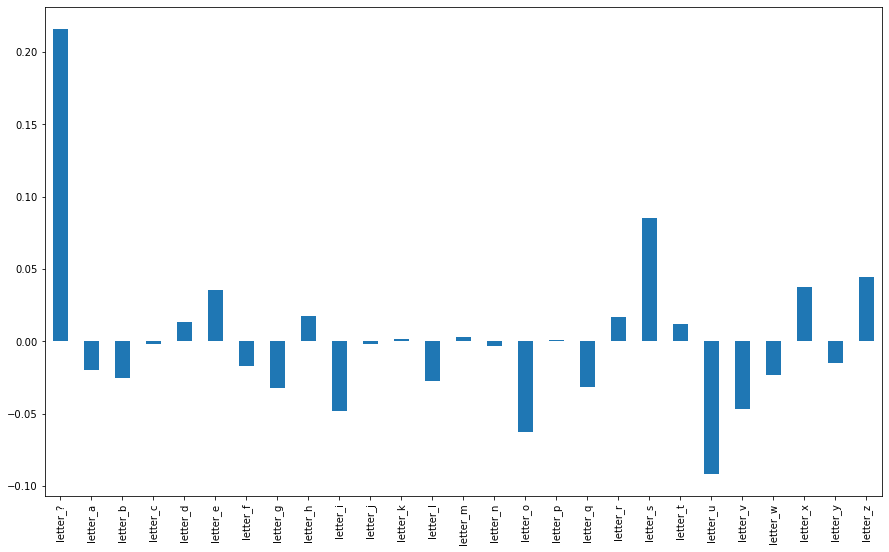

In [402]:
# Plot linear letter correlation with gained points

plt.figure(figsize=(15, 9))
train_rack_df.loc[:, train_rack_df.columns.str.startswith('letter_')].corrwith(train_rack_df['points']).plot(kind='bar')

In [403]:
# prepare games racks

train = turns_test_df.loc[turns_test_df['turn_number']==20][['game_id', 'rack']]
test = turns_train_df.loc[turns_train_df['turn_number']==20][['game_id', 'rack']]

final_racks_df = pd.concat([train, test], axis=0)
final_racks_df = Rack2Vec(final_racks_df)

In [404]:
# train model to predict gained points based only on current rack

model_racks = xgb.XGBRegressor(
    learning_rate=0.2,
    n_estimators=200,
    max_depth=8,
)

pipe_racks = Pipeline(steps=[
    ('scalar', MinMaxScaler()),
    ('xgb', model_racks)]
)

pipe_racks.fit(train_rack_df.drop(columns=['points']), train_rack_df['points'])

Pipeline(steps=[('scalar', MinMaxScaler()),
                ('xgb',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, enable_categorical=False,
                              gamma=0, gpu_id=-1, importance_type=None,
                              interaction_constraints='', learning_rate=0.2,
                              max_delta_step=0, max_depth=8, min_child_weight=1,
                              missing=nan, monotone_constraints='()',
                              n_estimators=200, n_jobs=8, num_parallel_tree=1,
                              predictor='auto', random_state=0, reg_alpha=0,
                              reg_lambda=1, scale_pos_weight=1, subsample=1,
                              tree_method='exact', validate_parameters=1,
                              verbosity=None))])

In [405]:
final_racks_df['pred_rack'] = pipe_racks.predict(final_racks_df.drop(columns='game_id'))
final_racks_df = final_racks_df[['game_id', 'pred_rack']]

## Final data preparation

In [406]:
# merge rack predictions and get some dummies

games_df = pd.merge(games_df, final_racks_df, on='game_id')
games_df = pd.get_dummies(games_df, columns=['lexicon'])
games_df = pd.get_dummies(games_df, columns=['time_control_name'])

In [407]:
# encode rating mode

rating_mode = {
    'RATED': 1,
    'CASUAL': 0
}

games_df['rating_mode'].replace(rating_mode, inplace=True)

In [408]:
# get nicknames

test = turns_test_df.loc[turns_test_df['turn_number']==2][['game_id', 'nickname']]
train = turns_train_df.loc[turns_train_df['turn_number']==2][['game_id', 'nickname']]

nicknames_df = pd.concat([train, test], axis=0)
nicknames_df.sort_values(by='game_id', inplace=True)

In [ ]:
names = [
    'BetterBot',
    'Churrrro',
    'rcg',
    'marvin',
    'EMC',
    'deathstar'
]

nicknames_df['nickname'].loc[~nicknames_df['nickname'].isin(names)] = 'Other'

In [410]:
# merge nicknames and get dummies

games_df = pd.merge(games_df, nicknames_df, on='game_id')
games_df = pd.get_dummies(games_df, columns=['nickname'])

In [412]:
# split games for train and test samples and get points from each turn

train_df = games_df.copy()
test_df = games_df.copy()

for turn in range(1, 21):
    train_df = train_df.merge(
        turns_train_df.loc[turns_train_df['turn_number'] == turn][['game_id', 'points']],
        on='game_id',
        how='left')
    test_df = test_df.merge(
        turns_test_df.loc[turns_test_df['turn_number'] == turn][['game_id', 'points']],
        on='game_id',
        how='left')
    
    train_df.rename(columns={'points': f'points_{turn}'}, inplace=True)
    test_df.rename(columns={'points': f'points_{turn}'}, inplace=True)

In [413]:
test_df.drop(columns=['points_20'], inplace=True)
    
train_df = train_df.dropna()
test_df = test_df.dropna()

<AxesSubplot:>

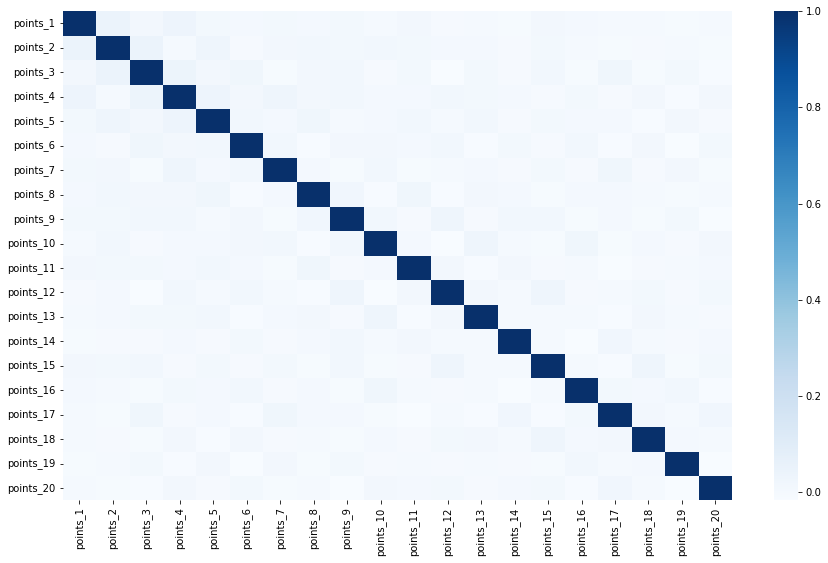

In [414]:
# unfortunately there is no correlation so we can drop it later

plt.figure(figsize=(15, 9))
corr = train_df.loc[:, train_df.columns.str.startswith('points_')].corr()
sb.heatmap(corr, cmap='Blues')

In [415]:
# try sum of points in previous rounds but its also no correlated

train_df['sum_19'] = train_df.loc[:, train_df.columns.str.startswith('points_')].drop(columns=['points_20']).sum(axis=1)
test_df['sum_19'] = test_df.loc[:, test_df.columns.str.startswith('points_')].sum(axis=1)

train_df['sum_19'].corr(train_df['points_20'])

0.0008629748165775754

<AxesSubplot:>

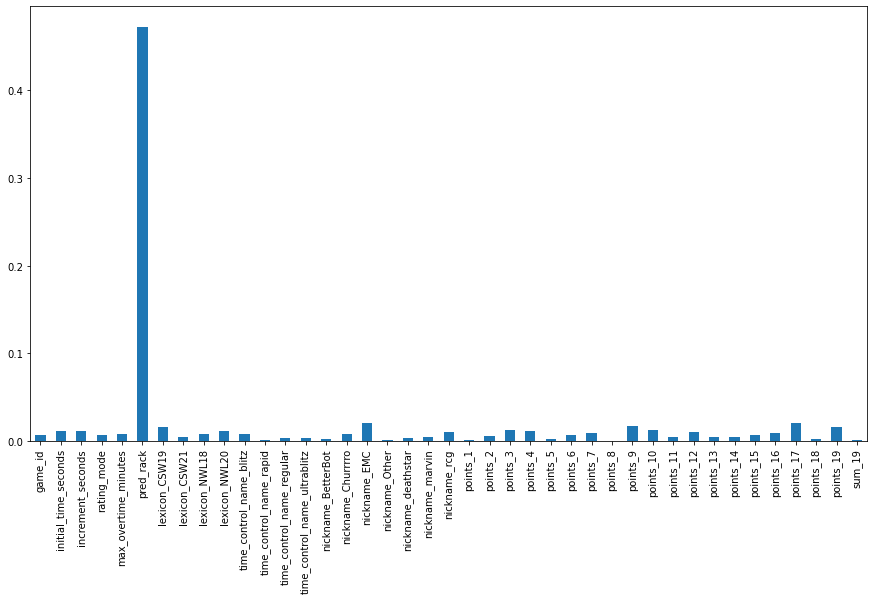

In [416]:
# all correlations plotted together

plt.figure(figsize=(15, 8))
train_df.drop(columns=['points_20']).corrwith(train_df['points_20']).abs().plot(kind='bar')

## Final model

In [421]:
model = xgb.XGBRegressor(
    learning_rate=0.05,
    n_estimators=100,
    max_depth=3,
    subsample=0.65
)
cv = StratifiedKFold(5)

pipe = Pipeline(steps=[
    ('scalar', MinMaxScaler()),
    ('xgb', model)]
)

scores = cross_val_score(pipe,
                         train_df.drop(columns=['points_20', 'game_id']),
                         train_df['points_20'],
                         scoring='neg_mean_squared_error',
                         cv=cv)

scores = np.sqrt(np.absolute(scores))
print('Mean RMSE: %.3f (%.3f)' % (scores.mean(), scores.std()))

/home/karol/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Mean RMSE: 17.556 (0.302)


In [422]:
pipe.fit(train_df.drop(columns=['points_20', 'game_id']), train_df['points_20'])


Pipeline(steps=[('scalar', MinMaxScaler()),
                ('xgb',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, enable_categorical=False,
                              gamma=0, gpu_id=-1, importance_type=None,
                              interaction_constraints='', learning_rate=0.05,
                              max_delta_step=0, max_depth=3, min_child_weight=1,
                              missing=nan, monotone_constraints='()',
                              n_estimators=100, n_jobs=8, num_parallel_tree=1,
                              predictor='auto', random_state=0, reg_alpha=0,
                              reg_lambda=1, scale_pos_weight=1, subsample=0.65,
                              tree_method='exact', validate_parameters=1,
                              verbosity=None))])

In [424]:
sample_df['points'] = pipe.predict(test_df.drop(columns=['game_id']))
sample_df.to_csv('submission.csv', index=False)